In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import math
from matplotlib import pyplot as plt
from scipy import stats
from sklearn.utils import resample
import sklearn as skl
from sklearn.metrics import r2_score, mean_squared_error
from statistics import mean, stdev, median
import statsmodels.api as sm
from dmba import stepwise_selection
from dmba import AIC_score
import random
import statsmodels.formula.api as smf
from random import choice
from collections import Counter
import datetime
%matplotlib inline
from pygam import LinearGAM, s, l

# Enable Jupyter Notebook's intellisense
%config IPCompleter.greedy=True
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

                   T       CTL       FTR        VZ      LVLT
2012-07-02  0.422496  0.140847  0.070879  0.554180 -0.519998
2012-07-03 -0.177448  0.066280  0.070879 -0.025976 -0.049999
2012-07-05 -0.160548 -0.132563  0.055128 -0.051956 -0.180000
2012-07-06  0.342205  0.132563  0.007875  0.140106 -0.359999
2012-07-09  0.136883  0.124279 -0.023626  0.253943  0.180000
...              ...       ...       ...       ...       ...
2015-06-25  0.049342 -1.600000 -0.040000 -0.187790 -0.330002
2015-06-26 -0.256586  0.039999 -0.070000  0.029650 -0.739998
2015-06-29 -0.098685 -0.559999 -0.060000 -0.504063 -1.360000
2015-06-30 -0.503298 -0.420000 -0.070000 -0.523829  0.199997
2015-07-01 -0.019737  0.080000 -0.050000  0.355811  0.139999

[754 rows x 5 columns]
                 XLI       QQQ       SPY       DIA       GLD    VXX       USO  \
2012-07-02 -0.376098  0.096313  0.028223 -0.242796  0.419998 -10.40  0.000000   
2012-07-03  0.376099  0.481576  0.874936  0.728405  0.490006  -3.52  0.250000   
2

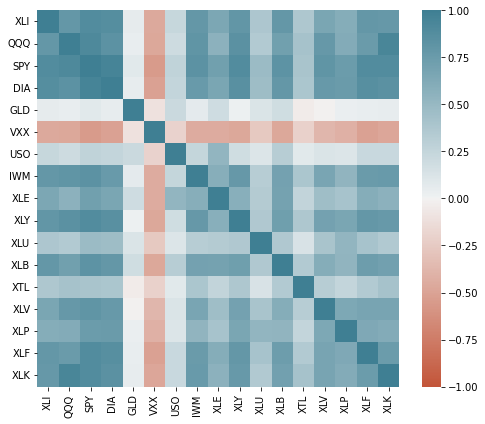

In [2]:
sp500_sym = pd.read_csv("D:\Data for python\practical-statistics-for-data-scientists-master\data\sp500_sectors.csv")
sp500_px = pd.read_csv("D:\Data for python\practical-statistics-for-data-scientists-master\data\sp500_data.csv", index_col=0)

# Table 1-7
# Determine telecommunications symbols
telecomSymbols = sp500_sym[sp500_sym['sector'] == 'telecommunications_services']['symbol']

# Filter data for dates July 2012 through June 2015
telecom = sp500_px.loc[sp500_px.index >= '2012-07-01', telecomSymbols]
telecom.corr()
print(telecom)

# Next we focus on funds traded on major exchanges (sector == 'etf').

etfs = sp500_px.loc[sp500_px.index > '2012-07-01', 
                    sp500_sym[sp500_sym['sector'] == 'etf']['symbol']]
print(etfs.head())

# Due to the large number of columns in this table, looking at the correlation matrix is cumbersome and it's more convenient to plot the correlation as a heatmap. The _seaborn_ package provides a convenient implementation for heatmaps.

fig, ax = plt.subplots(figsize=(7, 6))
ax = sns.heatmap(etfs.corr(), vmin=-1, vmax=1, 
                 cmap=sns.diverging_palette(20, 220, as_cmap=True),
                 ax=ax)

plt.tight_layout()
plt.show()

In [3]:
etfs.SPY.corr(etfs.VXX)

-0.5470743169438524

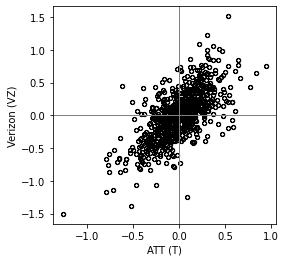

In [4]:
ax = telecom.plot.scatter(x='T', y='VZ', figsize=(4, 4), marker='$\u25EF$', color="black")
ax.set_xlabel('ATT (T)')
ax.set_ylabel('Verizon (VZ)')
ax.axhline(0, color='grey', lw=1)
ax.axvline(0, color='grey', lw=1)

In [5]:
telecom.columns

Index(['T', 'CTL', 'FTR', 'VZ', 'LVLT'], dtype='object')

In [6]:
kc_tax = pd.read_csv("D:\Data for python\practical-statistics-for-data-scientists-master\data\kc_tax.csv")

In [7]:
#kc_tax.SqFtTotLiving.sort_values(ascending=False)
kc_tax0 = kc_tax.loc[(kc_tax.TaxAssessedValue < 750000) &
(kc_tax.SqFtTotLiving > 100) &
(kc_tax.SqFtTotLiving < 3500), :]

Text(0, 0.5, 'Tax-Assessed Value')

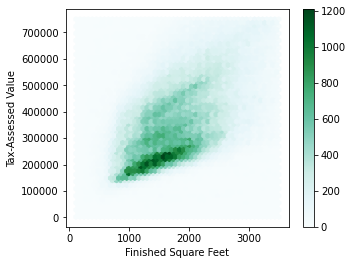

In [8]:
ax = kc_tax0.plot.hexbin(x='SqFtTotLiving', y='TaxAssessedValue',
gridsize=50, sharex=False, figsize=(5, 4))
ax.set_xlabel('Finished Square Feet')
ax.set_ylabel('Tax-Assessed Value')


In [9]:
#ax = sns.kdeplot(kc_tax0.SqFtTotLiving, kc_tax0.TaxAssessedValue, ax=ax)
#ax.set_xlabel('Finished Square Feet')
#ax.set_ylabel('Tax-Assessed Value')

In [10]:
kc_tax0

,TaxAssessedValue,SqFtTotLiving,ZipCode
1,206000.0,1870,98002.0
2,303000.0,1530,98166.0
3,361000.0,2000,98108.0
4,459000.0,3150,98108.0
5,223000.0,1570,98032.0
...,...,...,...
498244,375000.0,2230,98056.0
498245,316000.0,1710,98056.0
498246,340000.0,1930,98056.0
498247,132000.0,2930,98056.0


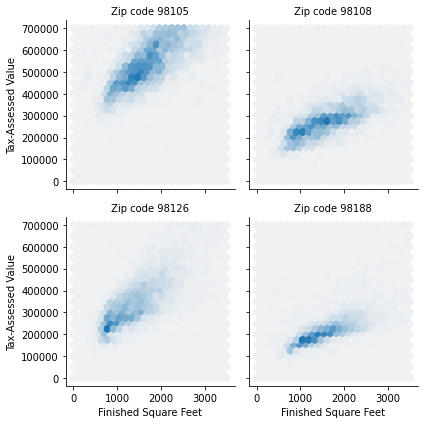

In [11]:
zip_codes = [98188, 98105, 98108, 98126]
kc_tax_zip = kc_tax0.loc[kc_tax0.ZipCode.isin(zip_codes),:]
kc_tax_zip
def hexbin(x, y, color, **kwargs):
    cmap = sns.light_palette(color, as_cmap=True)
    plt.hexbin(x, y, gridsize=25, cmap=cmap, **kwargs)
g = sns.FacetGrid(kc_tax_zip, col='ZipCode', col_wrap=2)
g.map(hexbin, 'SqFtTotLiving', 'TaxAssessedValue',
extent=[0, 3500, 0, 700000])
g.set_axis_labels('Finished Square Feet', 'Tax-Assessed Value')
g.set_titles('Zip code {col_name:.0f}')

In [12]:
loan_data = r"D:\Data for python\practical-statistics-for-data-scientists-master\data\loan_data.csv\loan_data.csv"

In [13]:
lc_loans = pd.read_csv(loan_data)

In [14]:
home_situation = {situation.title(): (lc_loans[lc_loans.home_ == situation].outcome.value_counts(normalize=True)) for situation in lc_loans.home_.unique()}
for situation in home_situation:
    home_situation[situation]["representation"] = lc_loans[lc_loans.home_ == situation].shape[0] / lc_loans.shape[0]
pd.DataFrame.from_dict(home_situation)


,Rent,Own,Mortgage
default,0.530467,0.507254,0.468433
paid off,0.469533,0.492746,0.531567
representation,0.000000,0.000000,0.000000


In [15]:
#lc_loans[lc_loans.purpose == ''].outcome.value_counts(normalize=True)
purpose_and_outcome = {purpose.title() :  (lc_loans[lc_loans.purpose == purpose].outcome.value_counts(normalize=True)) for purpose in lc_loans.purpose.unique()}
for purpose in purpose_and_outcome:
    purpose_and_outcome[purpose]["representation"] = lc_loans[lc_loans.purpose == purpose].shape[0] / lc_loans.shape[0]
pd.DataFrame.from_dict(purpose_and_outcome)


,Car,Small_Business,Other,Debt_Consolidation,Major_Purchase,Credit_Card,Home_Improvement,Moving,House,Medical,Wedding,Vacation
default,0.396662,0.685393,0.553696,0.510442,0.418423,0.4468,0.451131,0.539474,0.486413,0.501543,0.425688,0.526667
paid off,0.603338,0.314607,0.446304,0.489558,0.581577,0.5532,0.548869,0.460526,0.513587,0.498457,0.574312,0.473333
representation,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [16]:
def outcome_format(data):
    if data == "default":
        return 0
    elif data == "paid off":
        return 1

In [17]:
#lc_loans.outcome =  lc_loans.outcome.apply(outcome_format)

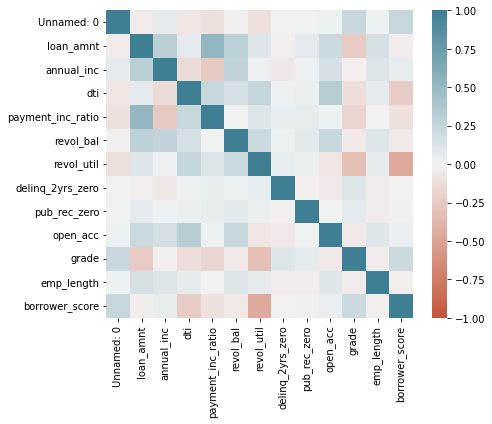

In [18]:
# Due to the large number of columns in this table, looking at the correlation matrix is cumbersome and it's more convenient to plot the correlation as a heatmap. The _seaborn_ package provides a convenient implementation for heatmaps.

fig, ax = plt.subplots(figsize=(7, 6))
ax = sns.heatmap(lc_loans.corr(), vmin=-1, vmax=1, 
                 cmap=sns.diverging_palette(20, 220, as_cmap=True),
                 ax=ax)

plt.tight_layout()
plt.show()

In [19]:
airline_stats = pd.read_csv(r"D:\Data for python\practical-statistics-for-data-scientists-master\data\airline_stats.csv")

Text(0.5, 0.98, '')

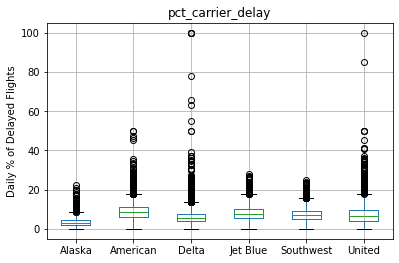

In [20]:
ax = airline_stats.boxplot(by='airline', column='pct_carrier_delay')
ax.set_xlabel('')
ax.set_ylabel('Daily % of Delayed Flights')
plt.suptitle('')

In [21]:
airline_stats

,pct_carrier_delay,pct_atc_delay,pct_weather_delay,airline
0,8.153226,1.971774,0.762097,American
1,5.959924,3.706107,1.585878,American
2,7.157270,2.706231,2.026706,American
3,12.100000,11.033333,0.000000,American
4,7.333333,3.365591,1.774194,American
...,...,...,...,...
33463,6.186422,8.798491,1.651940,Southwest
33464,9.522167,3.591133,0.261084,Southwest
33465,9.164179,2.664179,0.343284,Southwest
33466,5.152293,1.964520,0.122817,Southwest


C:\Users\flavi\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, '%Daily % of Delayed Flights')

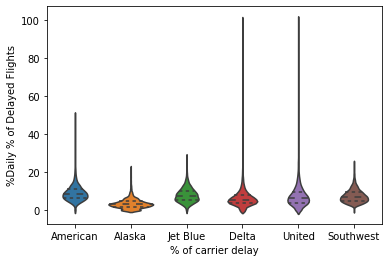

In [22]:
vl = sns.violinplot(airline_stats.airline, airline_stats.pct_carrier_delay, inner="quartile")
vl.set_xlabel("% of carrier delay")
vl.set_ylabel("%Daily % of Delayed Flights")

In [23]:
loans_income = pd.read_csv(r"D:\Data for python\practical-statistics-for-data-scientists-master\data\loans_income.csv")

results = []
for nrepeat in range(1000):
    sample = resample(loans_income, n_samples=50)
    results.append(sample.mean())
    results = pd.Series(results)
print('Bootstrap Statistics:')
print(f'original: {loans_income.mean()}')
print(f'bias: {results.mean() - loans_income.mean()}')
print(f'std. error: {results.std()}')

Bootstrap Statistics:
original: x    68760.51844
dtype: float64
bias: x   -7141.97844
dtype: float64
std. error: nan


In [24]:
def bootstrap_interval(original_sample, num_bootstraps, confidence=0.95, statistic=mean):
    results = []
    lower_tail =  round(( 1 - confidence ) * 0.5, 3)
    higher_tail = 100 - round(((1 - confidence) / 2 ), 3)
    for _ in range(num_bootstraps):
        sample = resample(original_sample)
        results.append(statistic(sample))
    min_ = np.percentile(results, lower_tail)
    max_ = np.percentile(results, higher_tail)
    return min_, max_ 

In [25]:
#fig, ax = plt.subplots(figsize=(4, 4))
#norm_sample = stats.norm.rvs(size=100)
#stats.probplot(norm_sample, plot=ax)

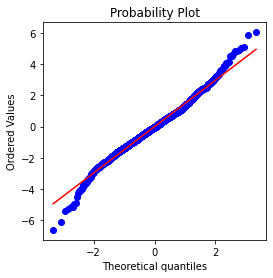

In [26]:
# Useful to see if a distribution fits a normal distribution
nflx = sp500_px.NFLX
nflx = np.diff(np.log(nflx[nflx>0]))
fig, ax = plt.subplots(figsize=(4, 4))
qqp = stats.probplot(nflx, plot=ax)
# similarly,  statsmodels.api.qqplot(nflx)

In [27]:
# Distributions
poisson = stats.poisson    # For events that occur at a constant rate, the number of events per unit of time or space
exponential = stats.expon  #  commonly used to measure the expected time for an event to occur,  the time or distance between one event and the next
weibull = stats.weibull_min  # With a changing event rate over time, used to describe various types of observed failures of components and phenomena

In [28]:
def mad(series):
    return sum(b - b.mean()) / series.size

In [29]:
def random_coin(flips):
    results = []
    for _ in range(flips):
        value = random.random()
        results.append(1 if value >= 0.5 else 0)
    return results

            

In [30]:
r = random_coin(50)

In [31]:
np.array(r).mean()



0.5

In [32]:
class RandomWalk:
    """A class to generate random walks."""
    
    def __init__(self, num_points=5000, max_steps=4):
        """Initialize attributes of a walk."""
        self.num_points = num_points
        self.max_steps = max_steps
        self.steps_range = np.arange(self.max_steps + 1)
        
        # All walks start at (0, 0).
        self.x_values = [0]
        self.y_values = [0]

    def fill_walk(self):
        """Calculate all the points in the walk."""
    
        # Keep taking steps until the walk reaches the desired length.
        while len(self.x_values) < self.num_points:
        
            # Decide which direction to go and how far to go in that direction.
            x_direction = choice([1, -1])
            x_distance = choice(self.steps_range)
            x_step = x_direction * x_distance
        
            y_direction = choice([1, -1])
            y_distance = choice(self.steps_range)
            y_step = y_direction * y_distance
        
            # Reject moves that go nowhere.
            if x_step == 0 and y_step == 0:
                continue
        
            # Calculate the new position.
            x = self.x_values[-1] + x_step
            y = self.y_values[-1] + y_step
        
            self.x_values.append(x)
            self.y_values.append(y)

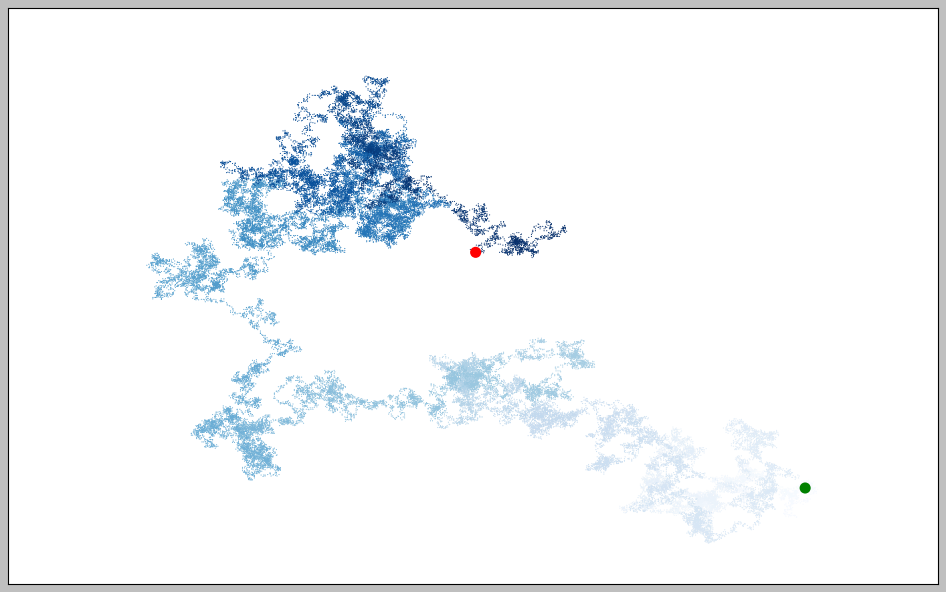

In [33]:

# Keep making new walks, as long as the program is active.

# Make a random walk.
rw = RandomWalk(50_000)
rw.fill_walk()

# Plot the points in the walk.
plt.style.use('classic')
fig, ax = plt.subplots(figsize=(15, 9))
point_numbers = range(rw.num_points)
ax.scatter(rw.x_values, rw.y_values, c=point_numbers, cmap=plt.cm.Blues,
    edgecolors='none', s=1)

# Emphasize the first and last points.
ax.scatter(0, 0, c='green', edgecolors='none', s=100)
ax.scatter(rw.x_values[-1], rw.y_values[-1], c='red', edgecolors='none',
    s=100)

# Remove the axes.
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

plt.show()


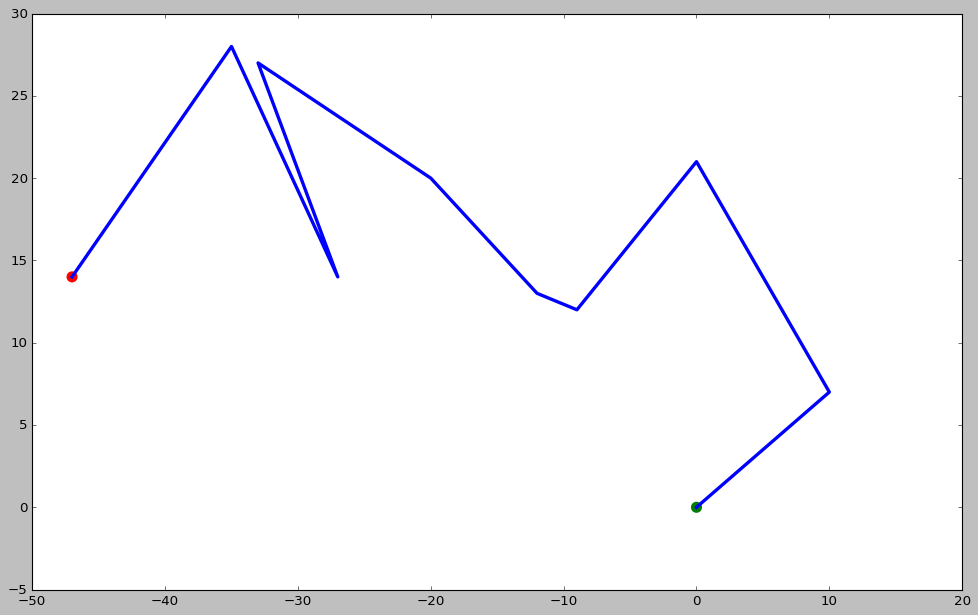

In [34]:
# Line Randomwalk
rnw = RandomWalk(10, max_steps=15)
rnw.fill_walk()
plt.style.use('classic')
fig, ax = plt.subplots(figsize=(15, 9))
ax.scatter(0, 0, c='green', edgecolors='none', s=100)
ax.scatter(rnw.x_values[-1], rnw.y_values[-1], c='red', edgecolors='none',
    s=100)
figure = plt.plot(rnw.x_values, rnw.y_values, lw=3)

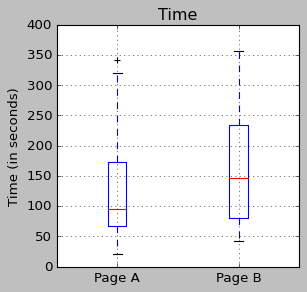

35.66666666666667


In [35]:
webpage_data = r"D:\Data for python\practical-statistics-for-data-scientists-master\data\web_page_data.csv"
session_times = pd.read_csv(webpage_data)
session_times.Time = 100 * session_times.Time

ax = session_times.boxplot(by='Page', column='Time',
                           figsize=(4, 4))
ax.set_xlabel('')
ax.set_ylabel('Time (in seconds)')
plt.suptitle('')

plt.tight_layout()
plt.show()

mean_a = session_times[session_times.Page == 'Page A'].Time.mean()
mean_b = session_times[session_times.Page == 'Page B'].Time.mean()
print(mean_b - mean_a)


Text(0, 0.5, 'Frequency')

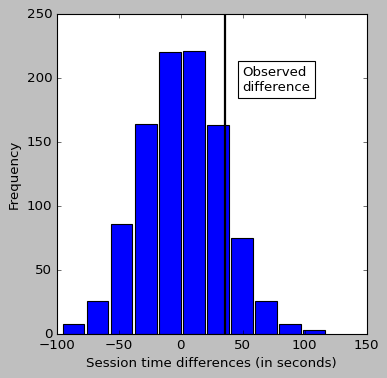

In [36]:
# Random Permutation of the values of A and B
def perm_fun(x, nA, nB):
    n = nA + nB
    idx_B = set(random.sample(range(n), nB))
    idx_A = set(range(n)) - idx_B
    return x.loc[idx_B].mean() - x.loc[idx_A].mean()

nA, nB = 21, 15
perm_diffs = [perm_fun(session_times.Time, nA, nB) for _ in range(1000)]
fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(perm_diffs, bins=11, rwidth=0.9)
ax.axvline(x = mean_b - mean_a, color='black', lw=2)
ax.text(50, 190, 'Observed\ndifference', bbox={'facecolor':'white'})
ax.set_xlabel('Session time differences (in seconds)')
ax.set_ylabel('Frequency')

In [37]:
np.mean(perm_diffs > mean_b - mean_a)

0.139

In [38]:
def bootstrap_interval(original_sample, num_bootstraps, confidence=0.95,
                       statistic=np.mean):
    """Provided with a sample from a dataset , uses bootstrapping on the sample
    and returns the interval in which the statistic of the dataset
    should be within. """
    results = []
    lower_tail = round((1 - confidence) * 0.5, 3)
    higher_tail = 100 - round(((1 - confidence) / 2), 3)
    for _ in range(num_bootstraps):
        sample = resample(original_sample)
        results.append(statistic(sample))
    min_ = np.percentile(results, lower_tail)
    max_ = np.percentile(results, higher_tail)
    return min_, max_


In [39]:
# My attempt at implementing bootstrap alternative approach
vals = session_times[session_times.Page == "Page A"]
pageA_stats = bootstrap_interval(vals, 1000)
vals2 = session_times[session_times.Page == "Page B"]
pageB_stats = bootstrap_interval(vals2, 1000)
np.array(pageB_stats) - np.array(pageA_stats)

C:\Users\flavi\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\fromnumeric.py:3438: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


array([22.11628571, 35.71125   ])

In [40]:
pd.Series(perm_diffs).describe()

count    1000.000000
mean        0.767810
std        32.355464
min       -96.104762
25%       -21.247619
50%         0.523810
75%        22.352381
max       117.495238
dtype: float64

In [41]:
def normal_cdf(x: float, mu: float = 0, sigma: float = 1) -> float:
    """returns the cumulative % of x in a normal distribution"""
    # scipy.stats.norm.cdf()
    return (1 + math.erf((x - mu) / math.sqrt(2) / sigma)) / 2

In [42]:
1 - normal_cdf(x=35.6, mu=1.074895, sigma=32.052443)

0.14070791123837045

In [44]:
# My attempt to solving problem on page 104   -  accepted null correctly but result is much different than book- then I modified it
def random_permutation(total, chance):
    # endeded up not being used 
    results = []
    for _ in range(total):
        pick = random.random()
        results.append(1 if pick > 0 and pick <= chance else 0)
    return pd.Series(results)

def perms(x, nA, nB):
    n = nA + nB
    idx_B = set(random.sample(range(n), nB))
    idx_A = set(range(n)) - idx_B
    one = x.loc[idx_B].mean()           # corrected from previous sum()
    two = x.loc[idx_A].mean()
    return (one - two) * 100

n_total = 46327
base_chance = 0.01  #changed from previous 0.008246
numA, numB = 23739, 22588

diffs = []
for _ in range(1000):
    values = conversion          # changed from random_permutation(n_total, base_chance)
    diffs.append(perms(values, numA, numB))
    

NameError: name 'conversion' is not defined

Text(0, 0.5, 'Frequency')

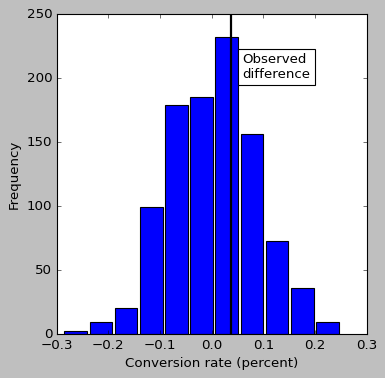

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(diffs, bins=11, rwidth=0.9)
ax.axvline(x = 0.0368, color='black', lw=2)
ax.text(0.06, 200, 'Observed\ndifference', bbox={'facecolor':'white'})
ax.set_xlabel('Conversion rate (percent)')
ax.set_ylabel('Frequency')

In [45]:
diff = pd.Series(diffs)
np.mean(diff > 0.0368)

C:\Users\flavi\AppData\Local\Temp/ipykernel_14240/1516800339.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  diff = pd.Series(diffs)


nan

In [46]:
diff.describe()

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
dtype: float64

In [47]:
1 - normal_cdf(0.0368, mu=0.004557, sigma=0.082120)

0.3472953800184163

Observed difference: 0.0368%


Text(0, 0.5, 'Frequency')

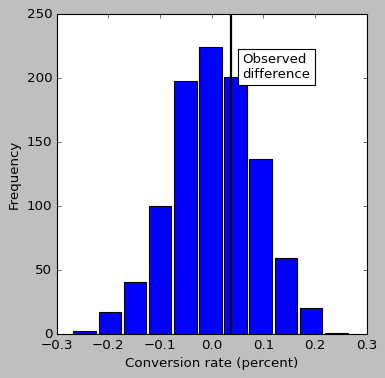

In [48]:
# Book's solution to problem on page 104
obs_pct_diff = 100 * (200 / 23739 - 182 / 22588)
print(f'Observed difference: {obs_pct_diff:.4f}%')
conversion = [0] * 45945
conversion.extend([1] * 382)
conversion = pd.Series(conversion)
perm_diffs = [100 * perm_fun(conversion, 23739, 22588)
for _ in range(1000)]
fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(perm_diffs, bins=11, rwidth=0.9)
ax.axvline(x=obs_pct_diff, color='black', lw=2)
ax.text(0.06, 200, 'Observed\ndifference', bbox={'facecolor':'white'})
ax.set_xlabel('Conversion rate (percent)')
ax.set_ylabel('Frequency')

In [49]:
pd.Series(perm_diffs).describe()

count    1000.000000
mean        0.004902
std         0.082228
min        -0.270027
25%        -0.054037
50%         0.006440
75%         0.058278
max         0.265628
dtype: float64

In [50]:
# Getting the P Value

1 - normal_cdf(0.0368, mu=-0.001958, sigma=0.083856)
#or
np.mean([diff > obs_pct_diff for diff in perm_diffs])


0.332

In [51]:
survivors = np.array([[200, 23739 - 200], [182, 22588 - 182]])
chi2, p_value, df, _ = stats.chi2_contingency(survivors)
print(f'p-value for single sided test: {p_value / 2:.4f}')

p-value for single sided test: 0.3498


In [52]:
#Student's T test :  scipy.stats.ttest_ind

res = stats.ttest_ind(session_times[session_times.Page == 'Page A'].Time,
session_times[session_times.Page == 'Page B'].Time,
equal_var=False)
print(f'p-value for single sided test: {res.pvalue / 2:.4f}')


p-value for single sided test: 0.1408


In [53]:
# ANOVA  - page 120 - ANOVA is a statistical procedure for analyzing
#  the results of an experiment with multiple groups.

four_sessions = pd.read_csv(r"D:\Data for python\practical-statistics-for-data-scientists-master\data\four_sessions.csv")

observed_variance = four_sessions.groupby('Page').mean().var()[0]
print('Observed means:', four_sessions.groupby('Page').mean().values.ravel())
print('Variance:', observed_variance)


def perm_test(df):
    df = df.copy()
    df['Time'] = np.random.permutation(df['Time'].values)
    return df.groupby('Page').mean().var()[0]


perm_variance = [perm_test(four_sessions) for _ in range(3000)]
print('Pr(Prob)', np.mean([var > observed_variance for var in perm_variance]))

Observed means: [172.8 182.6 175.6 164.6]
Variance: 55.426666666666655
Pr(Prob) 0.081


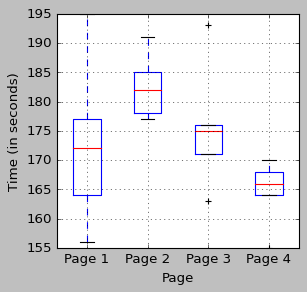

In [54]:
ax = four_sessions.boxplot(by='Page', column='Time',
                           figsize=(4, 4))
ax.set_xlabel('Page')
ax.set_ylabel('Time (in seconds)')
plt.suptitle('')
plt.title('')

plt.tight_layout()
plt.show()

# even though page b shows apparent advantages, the alpha 8% is not
#  enough to be considered statistically signifcant (> 5%)

In [55]:
### F-Statistic
# We can compute an ANOVA table using statsmodel.

model = smf.ols('Time ~ Page', data=four_sessions).fit()
                
aov_table = sm.stats.anova_lm(model)
print(aov_table)

res = stats.f_oneway(four_sessions[four_sessions.Page == 'Page 1'].Time, 
                     four_sessions[four_sessions.Page == 'Page 2'].Time,
                     four_sessions[four_sessions.Page == 'Page 3'].Time,
                     four_sessions[four_sessions.Page == 'Page 4'].Time)
print(f'F-Statistic: {res.statistic / 2:.4f}')
print(f'p-value: {res.pvalue / 2:.4f}')

            df  sum_sq     mean_sq         F    PR(>F)
Page       3.0   831.4  277.133333  2.739825  0.077586
Residual  16.0  1618.4  101.150000       NaN       NaN
F-Statistic: 1.3699
p-value: 0.0388


In [56]:
## Chi-Square Test
### Chi-Square Test: A Resampling Approach

# Table 3-4
click_rate = pd.read_csv(r"D:\Data for python\practical-statistics-for-data-scientists-master\data\click_rates.csv")
clicks = click_rate.pivot(index='Click', columns='Headline', values='Rate')
print(clicks)

# Table 3-5
row_average = clicks.mean(axis=1)
pd.DataFrame({
    'Headline A': row_average,
    'Headline B': row_average,
    'Headline C': row_average,
})

Headline  Headline A  Headline B  Headline C
Click                                       
Click             14           8          12
No-click         986         992         988


,Headline A,Headline B,Headline C
Click,,,
Click,11.333333,11.333333,11.333333
No-click,988.666667,988.666667,988.666667


In [57]:
# Resampling approach
box = [1] * 34
box.extend([0] * 2966)
random.shuffle(box)

def chi2(observed, expected):
    pearson_residuals = []
    for row, expect in zip(observed, expected):
        pearson_residuals.append([(observe - expect) ** 2 / expect
                                  for observe in row])
    # return sum of squares
    return np.sum(pearson_residuals)

expected_clicks = 34 / 3
expected_noclicks = 1000 - expected_clicks
expected = [34 / 3, 1000 - 34 / 3]
chi2observed = chi2(clicks.values, expected)

def perm_fun(box):
    sample_clicks = [sum(random.sample(box, 1000)),
                     sum(random.sample(box, 1000)),
                     sum(random.sample(box, 1000))]
    sample_noclicks = [1000 - n for n in sample_clicks]
    return chi2([sample_clicks, sample_noclicks], expected)

perm_chi2 = [perm_fun(box) for _ in range(2000)]

resampled_p_value = sum(perm_chi2 > chi2observed) / len(perm_chi2)
print(f'Observed chi2: {chi2observed:.4f}')
print(f'Resampled p-value: {resampled_p_value:.4f}')

chisq, pvalue, df, expected = stats.chi2_contingency(clicks)
print(f'Observed chi2: {chisq:.4f}')
print(f'p-value: {pvalue:.4f}')

Observed chi2: 1.6659
Resampled p-value: 0.4835
Observed chi2: 1.6659
p-value: 0.4348


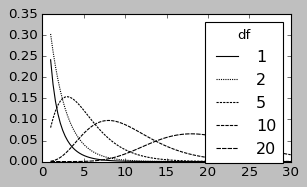

In [58]:
### Figure chi-sq distribution

x = [1 + i * (30 - 1) / 99 for i in range(100)]

chi = pd.DataFrame({
    'x': x,
    'chi_1': stats.chi2.pdf(x, df=1),
    'chi_2': stats.chi2.pdf(x, df=2),
    'chi_5': stats.chi2.pdf(x, df=5),
    'chi_10': stats.chi2.pdf(x, df=10),
    'chi_20': stats.chi2.pdf(x, df=20),
})
fig, ax = plt.subplots(figsize=(4, 2.5))
ax.plot(chi.x, chi.chi_1, color='black', linestyle='-', label='1')
ax.plot(chi.x, chi.chi_2, color='black', linestyle=(0, (1, 1)), label='2')
ax.plot(chi.x, chi.chi_5, color='black', linestyle=(0, (2, 1)), label='5')
ax.plot(chi.x, chi.chi_10, color='black', linestyle=(0, (3, 1)), label='10')
ax.plot(chi.x, chi.chi_20, color='black', linestyle=(0, (4, 1)), label='20')
ax.legend(title='df')

plt.tight_layout()
plt.show()

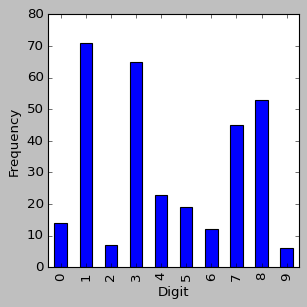

In [59]:
#### Scientific Fraud case

imanishi = pd.read_csv(r"D:\Data for python\practical-statistics-for-data-scientists-master\data\imanishi_data.csv")
imanishi.columns = [c.strip() for c in imanishi.columns]
ax = imanishi.plot.bar(x='Digit', y=['Frequency'], legend=False,
                      figsize=(4, 4))
ax.set_xlabel('Digit')
ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [60]:
frequencies = imanishi.Frequency
iman1 = [np.repeat(digit, frequencies[digit]) for digit in imanishi.Digit]
imanishi_array = np.concatenate(iman1)

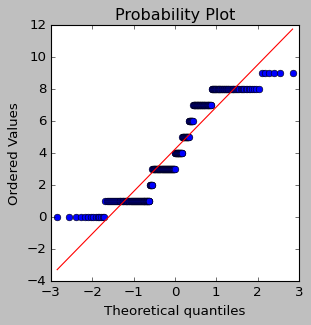

In [61]:
fig, ax = plt.subplots(figsize=(4, 4))
qqp = stats.probplot(imanishi_array, plot=ax)
# similarly,  statsmodels.api.qqplot(nflx)

In [62]:

signs = [{"sign":"Aries" ,"count":29}, {"sign":"Taurus", "count":24,} ,{"sign":"Gemini", "count":22},
{"sign":"Cancer", "count":19}, {"sign":"Leo", "count": 21}, {"sign":"Virgo", "count":18}, {"sign":"Libra", "count":19},
{"sign":"Scorpio", "count": 20}, {"sign":"Sagitarius", "count": 23}, {"sign":"Capricorn", "count":18},
{"sign":"Aquarius", "count":20}, {"sign":"Pisces", "count": 23}]

In [63]:
signs = pd.DataFrame.from_dict(signs)
signs

,sign,count
0,Aries,29
1,Taurus,24
2,Gemini,22
3,Cancer,19
4,Leo,21
5,Virgo,18
6,Libra,19
7,Scorpio,20
8,Sagitarius,23
9,Capricorn,18


In [64]:
expected = signs['count'].sum() / signs.sign.size
chi2 = 0
for sign in signs.sign:
    filt=  signs["sign"] == sign
    indic = signs.index[filt][0]
    value = signs["count"][indic]
    residual = value - expected
    chi2 +=  ((residual ** 2) /  expected)
chi2
    

5.093750000000001

In [65]:
def perm_signs():
    combination =  [random.choice(signs.sign) for y in range(256)]
    series= pd.Series(combination)
    return series.value_counts().var()    
        
def permuted_signs(permutations):
    return np.array([perm_signs() for _ in range(permutations)])
        
        

In [66]:
normal_signs_distribution = permuted_signs(3000)

In [67]:
normal_signs_distribution.mean()

21.482848484848486

In [68]:
details = pd.Series(normal_signs_distribution).describe()
details

count    3000.000000
mean       21.482848
std         9.020905
min         3.333333
25%        14.787879
50%        20.242424
75%        26.651515
max        68.787879
dtype: float64

In [69]:
normal_cdf(x= signs.var(), mu=details[1], sigma=details[2])



C:\Users\flavi\AppData\Local\Temp/ipykernel_14240/2920607897.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  normal_cdf(x= signs.var(), mu=details[1], sigma=details[2])


0.0991600932867856

In [70]:
import datetime, time

purchase_day =  datetime.datetime(2021, 8, 31, 0, 0, 0)
complete_day =  purchase_day + datetime.timedelta(days= 30*10)
datetime.datetime.ctime(complete_day)

'Mon Jun 27 00:00:00 2022'

In [71]:
#problem from  https://towardsdatascience.com/chi-square-test-with-python-d8ba98117626
# Goodness of Fit test
# Creation of data
data = [['CDU', 0.415, 57], ['SPD', 0.257, 26], ['Others', 0.328, 40]] 
df = pd.DataFrame(data, columns = ['Varname', 'prob_dist', 'observed_freq']) 
df['expected_freq'] = df['observed_freq'].sum() * df['prob_dist']

# significance level
alpha = 0.05

In [72]:
df

,Varname,prob_dist,observed_freq,expected_freq
0,CDU,0.415,57,51.045
1,SPD,0.257,26,31.611
2,Others,0.328,40,40.344


In [73]:
# Calcualtion of Chisquare test statistics
chi_square = 0
for i in range(len(df)):
    O = df.loc[i, 'observed_freq']
    E = df.loc[i, 'expected_freq']
    chi_square += (O-E)**2/E


# The p-value approach
print("Approach 1: The p-value approach to hypothesis testing in the decision rule")
p_value = 1 - stats.norm.cdf(chi_square, df['Varname'].nunique() - 1)
conclusion = "Failed to reject the null hypothesis."
if p_value <= alpha:
    conclusion = "Null Hypothesis is rejected."
        
print("chisquare-score is:", chi_square, " and p value is:", p_value)
print(conclusion)

Approach 1: The p-value approach to hypothesis testing in the decision rule
chisquare-score is: 1.693614940576721  and p value is: 0.6203442587006092
Failed to reject the null hypothesis.


In [74]:
# The critical value approach
print("\n--------------------------------------------------------------------------------------")
print("Approach 2: The critical value approach to hypothesis testing in the decision rule")
critical_value = stats.chi2.ppf(1-alpha, df['Varname'].nunique() - 1)
conclusion = "Failed to reject the null hypothesis."
if chi_square > critical_value:
    conclusion = "Null Hypothesis is rejected."
        
print("chisquare-score is:", chi_square, " and p value is:", critical_value)
print(conclusion)


--------------------------------------------------------------------------------------
Approach 2: The critical value approach to hypothesis testing in the decision rule
chisquare-score is: 1.693614940576721  and p value is: 5.991464547107979
Failed to reject the null hypothesis.


In [75]:
# In summary, for calculating power or required sample size, there are four moving
# parts:
# • Sample size
# • Effect size you want to detect
# • Significance level (alpha) at which the test will be conducted
# • Power
# Specify any three of them, and the fourth can be calculated.

In [107]:
# WORK
from collections import namedtuple
taxes = namedtuple("federal_taxes", ["IRPJ", "CSLL"])
trimesters = [28203.3, 29367.9, 104964.78, 110689.19]
ir_taxes = [round(n * 0.32 * 0.15, 2) for n in trimesters]
csll_taxes = [round(n * 0.32 * 0.09, 2) for n in trimesters]
total_taxes = list(zip(ir_taxes, csll_taxes))
all_taxes = [taxes(tax[0], tax[1]) for tax in total_taxes]
all_taxes

[federal_taxes(IRPJ=1353.76, CSLL=812.26),
 federal_taxes(IRPJ=1409.66, CSLL=845.8),
 federal_taxes(IRPJ=5038.31, CSLL=3022.99),
 federal_taxes(IRPJ=5313.08, CSLL=3187.85)]

In [77]:
## Power and Sample Size  PAGE 138
# statsmodels has a number of methods for power calculation
# 
# see e.g.: https://machinelearningmastery.com/statistical-power-and-power-analysis-in-python/

effect_size = sm.stats.proportion_effectsize(0.0121, 0.011)
analysis = sm.stats.TTestIndPower()
result = analysis.solve_power(effect_size=effect_size, 
                              alpha=0.05, power=0.8, alternative='larger')
print('Sample Size: %.3f' % result)

effect_size = sm.stats.proportion_effectsize(0.0165, 0.011)
analysis = sm.stats.TTestIndPower()
result = analysis.solve_power(effect_size=effect_size, 
                              alpha=0.05, power=0.8, alternative='larger')
print('Sample Size: %.3f' % result)

Sample Size: 116602.393
Sample Size: 5488.408


Chapter 4  Simple Linear Regression

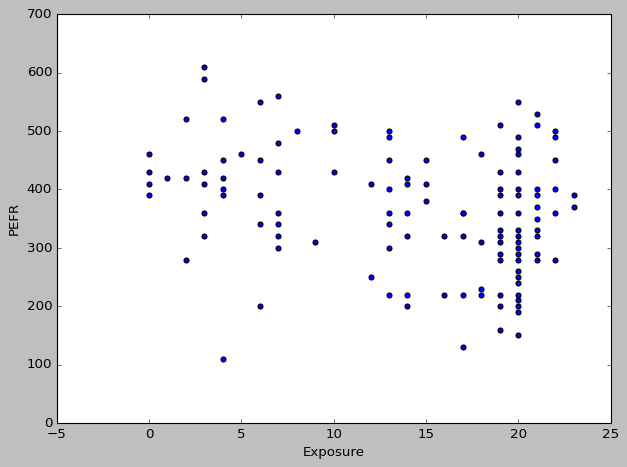

In [78]:
## Simple Linear Regression
### The Regression Equation

lung = pd.read_csv(r"D:\Data for python\practical-statistics-for-data-scientists-master\data\LungDisease.csv")

lung.plot.scatter(x='Exposure', y='PEFR')

plt.tight_layout()
plt.show()

Intercept: 424.582806573957
Coefficient Exposure: -4.1845764854614425


C:\Users\flavi\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\flavi\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


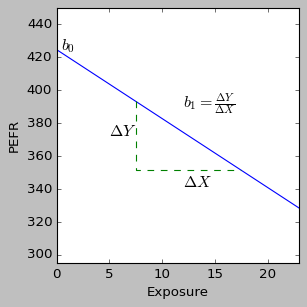

In [79]:
# We can use the `LinearRegression` model from _scikit-learn_.
from sklearn.linear_model import LinearRegression


predictors = ['Exposure']
outcome = 'PEFR'

model = LinearRegression()
model.fit(lung[predictors], lung[outcome])

print(f'Intercept: {model.intercept_}')
print(f'Coefficient Exposure: {model.coef_[0]}')

fig, ax = plt.subplots(figsize=(4, 4))
ax.set_xlim(0, 23)
ax.set_ylim(295, 450)
ax.set_xlabel('Exposure')
ax.set_ylabel('PEFR')
ax.plot((0, 23), model.predict([[0], [23]]))
ax.text(0.4, model.intercept_, r'$b_0$', size='larger')

x = [[7.5], [17.5]]
y = model.predict(x)
ax.plot((7.5, 7.5, 17.5), (y[0], y[1], y[1]), '--')
ax.text(5, np.mean(y), r'$\Delta Y$', size='larger')
ax.text(12, y[1] - 10, r'$\Delta X$', size='larger')
ax.text(12, 390, r'$b_1 = \frac{\Delta Y}{\Delta X}$', size='larger')

plt.tight_layout()
plt.show()

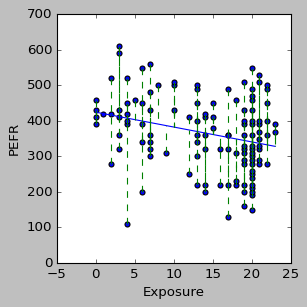

In [80]:
# Residual  (difference between predictions and known values)

fitted = model.predict(lung[predictors])
residuals = lung[outcome] - fitted

ax = lung.plot.scatter(x='Exposure', y='PEFR', figsize=(4, 4))
ax.plot(lung.Exposure, fitted)
for x, yactual, yfitted in zip(lung.Exposure, lung.PEFR, fitted): 
    ax.plot((x, x), (yactual, yfitted), '--', color='C1')

plt.tight_layout()
plt.show()

In [81]:
## Multiple linear regression

subset = ['AdjSalePrice', 'SqFtTotLiving', 'SqFtLot', 'Bathrooms', 
          'Bedrooms', 'BldgGrade']

house = pd.read_csv(r"D:\Data for python\practical-statistics-for-data-scientists-master\data\house_sales.csv", sep='\t')
print(house[subset].head())

predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 
              'Bedrooms', 'BldgGrade']
outcome = 'AdjSalePrice'

house_lm = LinearRegression()
house_lm.fit(house[predictors], house[outcome])

print(f'Intercept: {house_lm.intercept_:.3f}')
print('Coefficients:')
for name, coef in zip(predictors, house_lm.coef_):
    print(f' {name}: {coef}')


   AdjSalePrice  SqFtTotLiving  SqFtLot  Bathrooms  Bedrooms  BldgGrade
1      300805.0           2400     9373       3.00         6          7
2     1076162.0           3764    20156       3.75         4         10
3      761805.0           2060    26036       1.75         4          8
4      442065.0           3200     8618       3.75         5          7
5      297065.0           1720     8620       1.75         4          7
Intercept: -521871.368
Coefficients:
 SqFtTotLiving: 228.83060360240756
 SqFtLot: -0.06046682065306541
 Bathrooms: -19442.840398321103
 Bedrooms: -47769.95518521419
 BldgGrade: 106106.96307898113


In [82]:
### Assessing the Model
# _Scikit-learn_ provides a number of metrics to determine the quality of a 
# model. Here we use the `r2_score`.

fitted = house_lm.predict(house[predictors])
RMSE = np.sqrt(mean_squared_error(house[outcome], fitted))
r2 = r2_score(house[outcome], fitted)
print(f'RMSE: {RMSE:.0f}')
print(f'r2: {r2:.4f}')

# While _scikit-learn_ provides a variety of different metrics, _statsmodels_ 
# provides a more in-depth analysis of the linear regression model. 
# This package has two different ways of specifying the model, one that is 
# similar to _scikit-learn_ and one that allows specifying _R_-style formulas. 
# Here we use the first approach. As _statsmodels_ doesn't add an intercept 
# automaticaly, we need to add a constant column with value 1 to the predictors. 
# We can use the _pandas_ method assign for this.

model = sm.OLS(house[outcome], house[predictors].assign(const=1))
results = model.fit()
print(results.summary())

RMSE: 261220
r2: 0.5406
                            OLS Regression Results                            
Dep. Variable:           AdjSalePrice   R-squared:                       0.541
Model:                            OLS   Adj. R-squared:                  0.540
Method:                 Least Squares   F-statistic:                     5338.
Date:                Sat, 26 Feb 2022   Prob (F-statistic):               0.00
Time:                        09:08:11   Log-Likelihood:            -3.1517e+05
No. Observations:               22687   AIC:                         6.304e+05
Df Residuals:                   22681   BIC:                         6.304e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
SqFtTotLiving   228.83

In [83]:
### Model Selection and Stepwise Regression

predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms',
              'BldgGrade', 'PropertyType', 'NbrLivingUnits',
              'SqFtFinBasement', 'YrBuilt', 'YrRenovated', 
              'NewConstruction']

X = pd.get_dummies(house[predictors], drop_first=True)
X['NewConstruction'] = [1 if nc else 0 for nc in X['NewConstruction']]

house_full = sm.OLS(house[outcome], X.assign(const=1))
results = house_full.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           AdjSalePrice   R-squared:                       0.595
Model:                            OLS   Adj. R-squared:                  0.594
Method:                 Least Squares   F-statistic:                     2771.
Date:                Sat, 26 Feb 2022   Prob (F-statistic):               0.00
Time:                        09:08:11   Log-Likelihood:            -3.1375e+05
No. Observations:               22687   AIC:                         6.275e+05
Df Residuals:                   22674   BIC:                         6.276e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
SqFtTotLiving       

In [84]:
# We can use the `stepwise_selection` method from the _dmba_ package.

y = house[outcome]

def train_model(variables):
    if len(variables) == 0:
        return None
    model = LinearRegression()
    model.fit(X[variables], y)
    return model

def score_model(model, variables):
    if len(variables) == 0:
        return AIC_score(y, [y.mean()] * len(y), model, df=1)
    return AIC_score(y, model.predict(X[variables]), model)

best_model, best_variables = stepwise_selection(X.columns, train_model, score_model, 
                                                verbose=True)

print()
print(f'Intercept: {best_model.intercept_:.3f}')
print('Coefficients:')
for name, coef in zip(best_variables, best_model.coef_):
    print(f' {name}: {coef}')


Variables: SqFtTotLiving, SqFtLot, Bathrooms, Bedrooms, BldgGrade, NbrLivingUnits, SqFtFinBasement, YrBuilt, YrRenovated, NewConstruction, PropertyType_Single Family, PropertyType_Townhouse
Start: score=647988.32, constant
Step: score=633013.35, add SqFtTotLiving
Step: score=630793.74, add BldgGrade
Step: score=628230.29, add YrBuilt
Step: score=627784.16, add Bedrooms
Step: score=627602.21, add Bathrooms
Step: score=627525.65, add PropertyType_Townhouse
Step: score=627525.08, add SqFtFinBasement
Step: score=627524.98, add PropertyType_Single Family
Step: score=627524.98, unchanged None

Intercept: 6178645.017
Coefficients:
 SqFtTotLiving: 199.27755304201585
 BldgGrade: 137159.5602261976
 YrBuilt: -3565.4249392494557
 Bedrooms: -51947.38367361414
 Bathrooms: 42396.164527720524
 PropertyType_Townhouse: 84479.1620329995
 SqFtFinBasement: 7.046974967583083
 PropertyType_Single Family: 22912.055187017693


In [85]:
### Weighted regression
# We can calculate the Year from the date column using either a list 
# comprehension or the data frame's `apply` method.

house['Year'] = [int(date.split('-')[0]) for date in house.DocumentDate]
house['Year'] = house.DocumentDate.apply(lambda d: int(d.split('-')[0]))
house['Weight'] = house.Year - 2005

predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 
              'Bedrooms', 'BldgGrade']
outcome = 'AdjSalePrice'

house_wt = LinearRegression()
house_wt.fit(house[predictors], house[outcome], sample_weight=house.Weight)
pd.DataFrame({
    'predictor': predictors,
    'house_lm': house_lm.coef_,
    'house_wt': house_wt.coef_,
}).append({
    'predictor': 'intercept', 
    'house_lm': house_lm.intercept_,
    'house_wt': house_wt.intercept_,
}, ignore_index=True)



,predictor,house_lm,house_wt
0,SqFtTotLiving,228.830604,245.024089
1,SqFtLot,-0.060467,-0.292415
2,Bathrooms,-19442.840398,-26085.970109
3,Bedrooms,-47769.955185,-53608.876436
4,BldgGrade,106106.963079,115242.434726
5,intercept,-521871.368188,-584189.329446


In [86]:
residuals = pd.DataFrame({
    'abs_residual_lm': np.abs(house_lm.predict(house[predictors]) - house[outcome]),
    'abs_residual_wt': np.abs(house_wt.predict(house[predictors]) - house[outcome]),
    'Year': house['Year'],
})
print(residuals.head())

   abs_residual_lm  abs_residual_wt  Year
1    123750.814194    107108.553965  2014
2     59145.413089     96191.882094  2006
3    190108.725716    187004.492880  2007
4    198788.774412    196132.996857  2008
5     91774.996129     84277.577512  2013


In [87]:
def bootstrap_sample(sample: pd.DataFrame):
    results = []
    size = len(sample)
    for _ in range(size):
        ind = random.randint(1, size)
        results.append(sample.iloc[ind-1])
    return pd.DataFrame(results)

# BETTER USE DF.SAMPLE(REPLACE=TRUE)


In [88]:
# My attempt at bootstrapping the house sales sample 


def get_min_max(array, alpha):
    alfa = alpha * 100
    minimum = alfa / 2   
    maximum = (100 - minimum)  
    return (np.percentile(array, minimum), np.percentile(array, maximum))


def bootstrap_multi_reg_coefs(data: pd.DataFrame, predictors: list, outcome: str, n_times, alpha=0.05): 
    result = namedtuple("Interval",["Feature", "min", "max"]) 
    results = []
    model = LinearRegression()
    shape = (len(predictors), 1)
    coefficients = np.zeros(shape=shape)
    for n in range(n_times):
        bootstrap_sample = data.sample(n=shape[0], replace=True)
        model.fit(bootstrap_sample[predictors], bootstrap_sample[outcome])
        coefficients = np.column_stack((coefficients, np.array(model.coef_)))
    for i in range(shape[0]):
        minimum, maximum = get_min_max(coefficients[i], alpha)
        results.append(result(predictors[i], round(minimum,2), round(maximum,2)))
    return results




In [89]:
## Factor variables in regression
### Dummy Variables Representation


print(pd.get_dummies(house['PropertyType']).head(6))

print(pd.get_dummies(house['PropertyType'], drop_first=True).head(6))

predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms',
              'BldgGrade', 'PropertyType']

X = pd.get_dummies(house[predictors], drop_first=True)

house_lm_factor = LinearRegression()
house_lm_factor.fit(X, house[outcome])

print(f'Intercept: {house_lm_factor.intercept_:.3f}')
print('Coefficients:')
for name, coef in zip(X.columns, house_lm_factor.coef_):
    print(f' {name}: {coef}')

   Multiplex  Single Family  Townhouse
1          1              0          0
2          0              1          0
3          0              1          0
4          0              1          0
5          0              1          0
6          0              0          1
   Single Family  Townhouse
1              0          0
2              1          0
3              1          0
4              1          0
5              1          0
6              0          1
Intercept: -446841.366
Coefficients:
 SqFtTotLiving: 223.37362892503805
 SqFtLot: -0.07036798136812195
 Bathrooms: -15979.013473415263
 Bedrooms: -50889.73218483014
 BldgGrade: 109416.30516146208
 PropertyType_Single Family: -84678.21629549275
 PropertyType_Townhouse: -115121.97921609186


In [90]:
pd.DataFrame(house['ZipCode'].value_counts()).transpose()

,98038,98103,98042,98115,98117,98052,98034,98033,98059,98074,98053,98118,98029,98126,98133,98006,98023,98065,98058,98125,98056,98199,98075,98122,98027,98116,98106,98155,98001,98112,98168,98144,98055,98105,98136,98031,98107,98004,98008,98092,98146,98178,98030,98119,98028,98072,98040,98019,98003,98198,98045,98177,98077,98166,98022,98002,98011,98108,98109,98005,98032,98007,98102,98188,98070,98014,98010,98047,98039,98148,98051,98024,98354,98050,98057,98288,98224,98068,98113,98043
ZipCode,788,671,641,620,619,614,575,517,513,502,499,492,475,473,465,460,455,430,420,409,402,393,388,380,366,364,361,358,358,357,332,332,332,313,310,308,296,293,291,289,287,266,263,260,252,245,244,242,241,225,222,216,204,193,188,180,163,155,149,133,121,112,106,101,89,85,56,48,47,40,32,31,9,7,4,4,3,1,1,1


In [91]:
### Factor Variables with many levels

predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 
              'Bedrooms', 'BldgGrade']
outcome = 'AdjSalePrice'

house_lm = LinearRegression()
house_lm.fit(house[predictors], house[outcome])


zip_groups = pd.DataFrame([
    *pd.DataFrame({
        'ZipCode': house['ZipCode'],
        'residual' : house[outcome] - house_lm.predict(house[predictors]),
    })
    .groupby(['ZipCode'])
    .apply(lambda x: {
        'ZipCode': x.iloc[0,0],
        'count': len(x),
        'median_residual': x.residual.median()
    })
]).sort_values('median_residual')
zip_groups['cum_count'] = np.cumsum(zip_groups['count'])
zip_groups['ZipGroup'] = pd.qcut(zip_groups['cum_count'], 5, labels=False, retbins=False)
zip_groups.head()
print(zip_groups.ZipGroup.value_counts().sort_index())

to_join = zip_groups[['ZipCode', 'ZipGroup']].set_index('ZipCode')
house = house.join(to_join, on='ZipCode')
house['ZipGroup'] = house['ZipGroup'].astype('category')


0    16
1    16
2    16
3    16
4    16
Name: ZipGroup, dtype: int64


In [92]:
print(f'Intercept: {best_model.intercept_:.3f}')
print('Coefficients:')
for name, coef in zip(best_variables, best_model.coef_):
    print(f' {name}: {coef}')

Intercept: 6178645.017
Coefficients:
 SqFtTotLiving: 199.27755304201585
 BldgGrade: 137159.5602261976
 YrBuilt: -3565.4249392494557
 Bedrooms: -51947.38367361414
 Bathrooms: 42396.164527720524
 PropertyType_Townhouse: 84479.1620329995
 SqFtFinBasement: 7.046974967583083
 PropertyType_Single Family: 22912.055187017693


In [121]:
# removing some correlated predictors ~F

predictors = ['Bedrooms', 'BldgGrade', 'PropertyType', 'YrBuilt']
outcome = 'AdjSalePrice'

X = pd.get_dummies(house[predictors], drop_first=True)

reduced_lm = LinearRegression()
reduced_lm.fit(X, house[outcome])

print(f'Intercept: {reduced_lm.intercept_:.3f}')
print('Coefficients:')
for name, coef in zip(X.columns, reduced_lm.coef_):
    print(f' {name}: {coef}')

Intercept: 4913973.344
Coefficients:
 Bedrooms: 27150.537230219703
 BldgGrade: 248997.79366212635
 YrBuilt: -3211.7448621551157
 PropertyType_Single Family: -19898.495340501973
 PropertyType_Townhouse: -47355.436873344275


In [122]:
### Confounding variables   

predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms',
              'BldgGrade', 'PropertyType', 'ZipGroup']
outcome = 'AdjSalePrice'

X = pd.get_dummies(house[predictors], drop_first=True)

confounding_lm = LinearRegression()
confounding_lm.fit(X, house[outcome])

print(f'Intercept: {confounding_lm.intercept_:.3f}')
print('Coefficients:')
for name, coef in zip(X.columns, confounding_lm.coef_):
    print(f' {name}: {coef}')

Intercept: -666637.469
Coefficients:
 SqFtTotLiving: 210.6126600558013
 SqFtLot: 0.45498713854659734
 Bathrooms: 5928.425640001383
 Bedrooms: -41682.871840744585
 BldgGrade: 98541.18352726001
 PropertyType_Single Family: 19323.625287919636
 PropertyType_Townhouse: -78198.72092762364
 ZipGroup_1: 53317.17330659805
 ZipGroup_2: 116251.5888356354
 ZipGroup_3: 178360.53178793372
 ZipGroup_4: 338408.60185652063


In [123]:
### Interactions and Main Effects

model = smf.ols(formula='AdjSalePrice ~  SqFtTotLiving*ZipGroup + SqFtLot + ' +
     'Bathrooms + Bedrooms + BldgGrade + PropertyType', data=house)
results = model.fit()
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:           AdjSalePrice   R-squared:                       0.682
Model:                            OLS   Adj. R-squared:                  0.682
Method:                 Least Squares   F-statistic:                     3247.
Date:                Sat, 26 Feb 2022   Prob (F-statistic):               0.00
Time:                        10:27:05   Log-Likelihood:            -3.1098e+05
No. Observations:               22687   AIC:                         6.220e+05
Df Residuals:                   22671   BIC:                         6.221e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

In [124]:
# > Results differ from R due to different binning. Enforcing the same binning gives identical results

## Testing the Assumptions: Regression Diagnostics
### Outliers

# The _statsmodels_ package has the most developed support for outlier analysis.

house_98105 = house.loc[house['ZipCode'] == 98105, ]

predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms',
              'BldgGrade']
outcome = 'AdjSalePrice'

house_outlier = sm.OLS(house_98105[outcome], house_98105[predictors].assign(const=1))
result_98105 = house_outlier.fit()
print(result_98105.summary())

                            OLS Regression Results                            
Dep. Variable:           AdjSalePrice   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.792
Method:                 Least Squares   F-statistic:                     238.7
Date:                Sat, 26 Feb 2022   Prob (F-statistic):          1.69e-103
Time:                        10:27:05   Log-Likelihood:                -4226.0
No. Observations:                 313   AIC:                             8464.
Df Residuals:                     307   BIC:                             8486.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
SqFtTotLiving   209.6023     24.408      8.587

In [125]:
# The `OLSInfluence` class is initialized with the OLS regression results and gives 
# access to a number of usefule properties. Here we use the studentized residuals.
# GETTING THE OUTLIER FOR THAT SPECIFIC ZIPCODE   ~f
from statsmodels.stats.outliers_influence import OLSInfluence

influence = OLSInfluence(result_98105)
sresiduals = influence.resid_studentized_internal

print(sresiduals.idxmin(), sresiduals.min())

print(result_98105.resid.loc[sresiduals.idxmin()])

outlier = house_98105.loc[sresiduals.idxmin(), :]   # housing 
print('AdjSalePrice', outlier[outcome])
print(outlier[predictors])

24333 -4.326731804078557
-757753.6192115815
AdjSalePrice 119748.0
SqFtTotLiving    2900
SqFtLot          7276
Bathrooms         3.0
Bedrooms            6
BldgGrade           7
Name: 24333, dtype: object


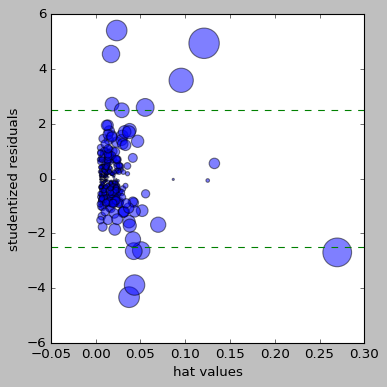

,Original,Influential removed
SqFtTotLiving,209.602346,230.052569
SqFtLot,38.933315,33.141600
Bathrooms,2282.264145,-16131.879785
Bedrooms,-26320.268796,-22887.865318
BldgGrade,130000.099737,114870.559737
const,-772549.862447,-647137.096716


In [126]:
# The package _statsmodel_ provides a number of plots to analyze the data point influence

influence = OLSInfluence(result_98105)
fig, ax = plt.subplots(figsize=(5, 5))
ax.axhline(-2.5, linestyle='--', color='C1')
ax.axhline(2.5, linestyle='--', color='C1')
ax.scatter(influence.hat_matrix_diag, influence.resid_studentized_internal, 
           s=1000 * np.sqrt(influence.cooks_distance[0]),
           alpha=0.5)

ax.set_xlabel('hat values')
ax.set_ylabel('studentized residuals')

plt.tight_layout()
plt.show()

mask = [dist < .08 for dist in influence.cooks_distance[0]]
house_infl = house_98105.loc[mask]             # Removed influentials

ols_infl = sm.OLS(house_infl[outcome], house_infl[predictors].assign(const=1))
result_infl = ols_infl.fit()

pd.DataFrame({
    'Original': result_98105.params,
    'Influential removed': result_infl.params,
})


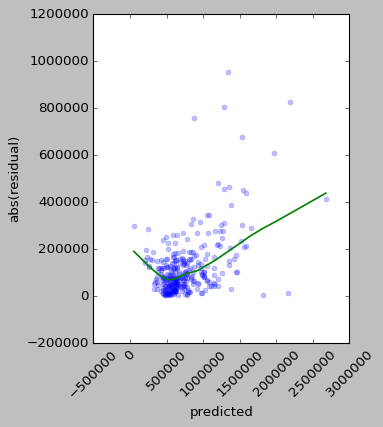

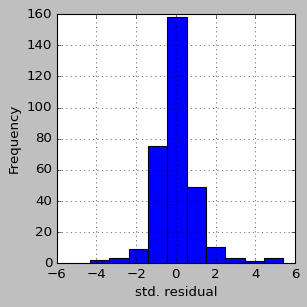

In [127]:
### Heteroskedasticity, Non-Normality and Correlated Errors

# The `regplot` in _seaborn_ allows adding a lowess smoothing line to the scatterplot.

fig, ax = plt.subplots(figsize=(5, 5))
sns.regplot(x=result_98105.fittedvalues, y=np.abs(result_98105.resid), 
            scatter_kws={'alpha': 0.25},
            line_kws={'color': 'C1'},
            lowess=True, ax=ax)
ax.set_xlabel('predicted')
ax.set_ylabel('abs(residual)')

plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

fig, ax = plt.subplots(figsize=(4, 4))
pd.Series(influence.resid_studentized_internal).hist(ax=ax)
ax.set_xlabel('std. residual')
ax.set_ylabel('Frequency')


plt.tight_layout()
plt.show()


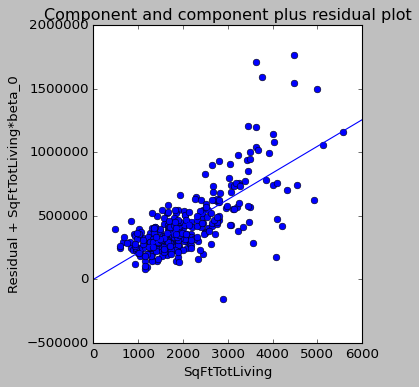

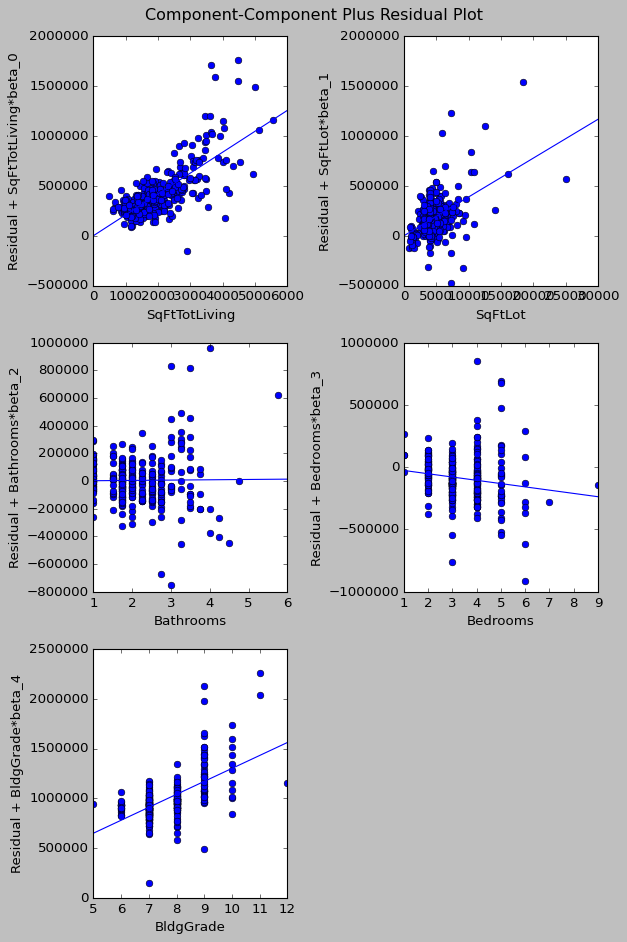

In [128]:
### Partial Residual Plots and Nonlinearity

fig, ax = plt.subplots(figsize=(5, 5))
fig = sm.graphics.plot_ccpr(result_98105, 'SqFtTotLiving', ax=ax)

plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(8, 12))
fig = sm.graphics.plot_ccpr_grid(result_98105, fig=fig)

In [129]:
### Polynomial and Spline Regression

model_poly = smf.ols(formula='AdjSalePrice ~  SqFtTotLiving + np.power(SqFtTotLiving, 2) + ' + 
                'SqFtLot + Bathrooms + Bedrooms + BldgGrade', data=house_98105)
result_poly = model_poly.fit()
print(result_poly.summary())

                            OLS Regression Results                            
Dep. Variable:           AdjSalePrice   R-squared:                       0.806
Model:                            OLS   Adj. R-squared:                  0.802
Method:                 Least Squares   F-statistic:                     211.6
Date:                Sat, 26 Feb 2022   Prob (F-statistic):          9.95e-106
Time:                        10:27:07   Log-Likelihood:                -4217.9
No. Observations:                 313   AIC:                             8450.
Df Residuals:                     306   BIC:                             8476.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

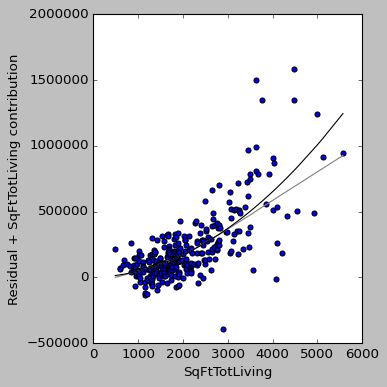

0.03879128168231151


In [130]:
# The statsmodels implementation of a partial residual plot works only for linear term. 
# Here is an implementation of a partial residual plot that, while inefficient, works for the polynomial regression.

def partialResidualPlot(model, df, outcome, feature, ax):
    y_pred = model.predict(df)
    copy_df = df.copy()
    for c in copy_df.columns:
        if c == feature:
            continue
        copy_df[c] = 0.0
    feature_prediction = model.predict(copy_df)
    results = pd.DataFrame({
        'feature': df[feature],
        'residual': df[outcome] - y_pred,
        'ypartial': feature_prediction - model.params[0],
    })
    results = results.sort_values(by=['feature'])
    smoothed = sm.nonparametric.lowess(results.ypartial, results.feature, frac=1/3)
    
    ax.scatter(results.feature, results.ypartial + results.residual)
    ax.plot(smoothed[:, 0], smoothed[:, 1], color='gray')
    ax.plot(results.feature, results.ypartial, color='black')
    ax.set_xlabel(feature)
    ax.set_ylabel(f'Residual + {feature} contribution')
    return ax

fig, ax = plt.subplots(figsize=(5, 5))
partialResidualPlot(result_poly, house_98105, 'AdjSalePrice', 'SqFtTotLiving', ax)

plt.tight_layout()
plt.show()
print(result_poly.params[2])

                            OLS Regression Results                            
Dep. Variable:           AdjSalePrice   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.807
Method:                 Least Squares   F-statistic:                     131.8
Date:                Sat, 26 Feb 2022   Prob (F-statistic):          7.10e-104
Time:                        10:27:08   Log-Likelihood:                -4211.4
No. Observations:                 313   AIC:                             8445.
Df Residuals:                     302   BIC:                             8486.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


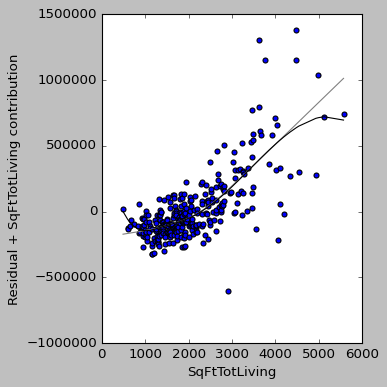

In [131]:
### Splines

formula = ('AdjSalePrice ~ bs(SqFtTotLiving, df=6, degree=3) + ' + 
           'SqFtLot + Bathrooms + Bedrooms + BldgGrade')
model_spline = smf.ols(formula=formula, data=house_98105)
result_spline = model_spline.fit()
print(result_spline.summary())

fig, ax = plt.subplots(figsize=(5, 5))
partialResidualPlot(result_spline, house_98105, 'AdjSalePrice', 'SqFtTotLiving', ax)

plt.tight_layout()
plt.show()

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:  00:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
C:\Users\flavi\AppData\Local\Temp/ipykernel_14240/627546178.py:12: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      7.6772
Link Function:                     IdentityLink Log Likelihood:                                 -7833.1159
Number of Samples:                          313 AIC:                                            15683.5863
                                                AICc:                                             15684.14
                                                GCV:                                      30838885095.1678
                                                Scale:                                    29480381715.8293
                                                Pseudo R-Squared:                                   0.8117
Feature Function                  Lam

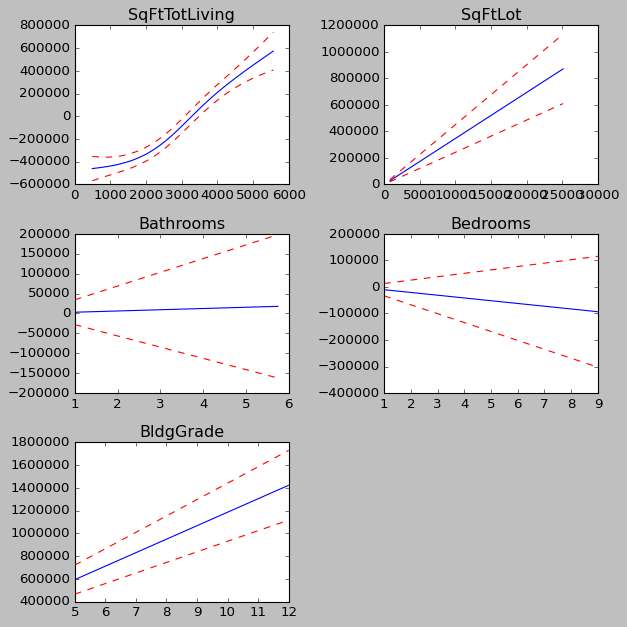

In [132]:
### Generalized Additive Models

predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 
              'Bedrooms', 'BldgGrade']
outcome = 'AdjSalePrice'
X = house_98105[predictors].values
y = house_98105[outcome]

## model
gam = LinearGAM(s(0, n_splines=12) + l(1) + l(2) + l(3) + l(4))
gam.gridsearch(X, y)
print(gam.summary())

fig, axes = plt.subplots(figsize=(8, 8), ncols=2, nrows=3)

titles = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms', 'BldgGrade']
for i, title in enumerate(titles):
    ax = axes[i // 2, i % 2]
    XX = gam.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
    ax.set_title(titles[i]);
    
axes[2][1].set_visible(False)

plt.tight_layout()
plt.show()


In [133]:
house

,DocumentDate,SalePrice,PropertyID,PropertyType,ym,zhvi_px,zhvi_idx,AdjSalePrice,NbrLivingUnits,SqFtLot,SqFtTotLiving,SqFtFinBasement,Bathrooms,Bedrooms,BldgGrade,YrBuilt,YrRenovated,TrafficNoise,LandVal,ImpsVal,ZipCode,NewConstruction,Year,Weight,ZipGroup
1,2014-09-16,280000,1000102,Multiplex,2014-09-01,405100,0.930836,300805.0,2,9373,2400,0,3.00,6,7,1991,0,0,70000,229000,98002,False,2014,9,2
2,2006-06-16,1000000,1200013,Single Family,2006-06-01,404400,0.929228,1076162.0,1,20156,3764,1452,3.75,4,10,2005,0,0,203000,590000,98166,True,2006,1,2
3,2007-01-29,745000,1200019,Single Family,2007-01-01,425600,0.977941,761805.0,1,26036,2060,900,1.75,4,8,1947,0,0,183000,275000,98166,False,2007,2,2
4,2008-02-25,425000,2800016,Single Family,2008-02-01,418400,0.961397,442065.0,1,8618,3200,1640,3.75,5,7,1966,0,0,104000,229000,98168,False,2008,3,2
5,2013-03-29,240000,2800024,Single Family,2013-03-01,351600,0.807904,297065.0,1,8620,1720,0,1.75,4,7,1948,0,0,104000,205000,98168,False,2013,8,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27057,2011-04-08,325000,9842300710,Single Family,2011-04-01,318700,0.732307,443803.0,1,5468,1480,590,1.75,3,7,1951,0,0,201000,172000,98126,False,2011,6,3
27058,2007-09-28,1580000,9845500010,Single Family,2007-09-01,433500,0.996094,1586196.0,1,23914,4720,910,4.50,4,11,2000,0,1,703000,951000,98040,False,2007,2,4
27061,2012-07-09,165000,9899200010,Single Family,2012-07-01,325300,0.747472,220744.0,1,11170,1070,0,1.00,4,6,1971,0,0,92000,130000,98055,False,2012,7,0
27062,2006-05-26,315000,9900000355,Single Family,2006-05-01,400600,0.920496,342207.0,1,6223,1345,0,2.00,3,7,1939,0,0,103000,212000,98166,False,2006,1,2
